In [1]:
import requests
import copy
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#extract ifsc wiki page and find all tables
mainPage = requests.get("https://en.wikipedia.org/wiki/IFSC_Climbing_World_Championships")
mainSoup = BeautifulSoup(mainPage.content, 'html.parser')
mainTables = list(mainSoup.find_all(class_="wikitable plainrowheaders"))

In [3]:
#Make each events table a list
mensLeadTable = list(mainTables[0].find_all('td'))
mensBoulderTable = list(mainTables[1].find_all('td'))
mensSpeedTable = list(mainTables[2].find_all('td'))
mensCombinedTable = list(mainTables[3].find_all('td'))

womensLeadTable = list(mainTables[4].find_all('td'))
womensBoulderTable = list(mainTables[5].find_all('td'))
womensSpeedTable = list(mainTables[6].find_all('td'))
womensCombinedTable = list(mainTables[7].find_all('td'))

In [4]:
#Function the names that have their own wikipeida page, 
#extract the name as well as the sub-link to the page
def nameCollection(wikiTable):
    nameList = []
    innerList = []
        
    for data in wikiTable:  
        if data.has_attr('align'):
            continue
        else:
            innerList = [data.find_all('a')[1].get_text(),data.find_all('a')[1]['href']]
            
        if innerList not in nameList and '/w/' not in innerList[1]:    
            nameList.append(innerList)
    return nameList

In [5]:
#place data in lists
mensLeadNames = nameCollection(mensLeadTable)
mensBoulderNames = nameCollection(mensBoulderTable)
mensSpeedNames = nameCollection(mensSpeedTable)
mensCombinedNames = nameCollection(mensCombinedTable)

womensLeadNames = nameCollection(womensLeadTable)
womensBoulderNames = nameCollection(womensBoulderTable)
womensSpeedNames = nameCollection(womensSpeedTable)
womensCombinedNames = nameCollection(womensCombinedTable)

fullMensNames = copy.deepcopy(mensLeadNames) + copy.deepcopy(mensBoulderNames) + copy.deepcopy(mensSpeedNames) + copy.deepcopy(mensCombinedNames)
fullWomensNames = copy.deepcopy(womensLeadNames) + copy.deepcopy(womensBoulderNames) + copy.deepcopy(womensSpeedNames) + copy.deepcopy(womensCombinedNames)

In [6]:
#go through all athlete wikis and collect height/weight information.
#this function also partially validates data by removing incorrect data
def appendNameData(nameList):
    for name in nameList:
        namePage = requests.get("https://en.wikipedia.org" + name[1])
        nameSoup = BeautifulSoup(namePage.content, 'html.parser')
        infoTable = list(nameSoup.find_all(class_="infobox vcard"))
        infoRows = list(infoTable[0].find_all("tr"))
        for row in infoRows:
            if list(row.children)[0].name != "th":
                continue

            if list(row.children)[0].getText() == "Height":
                if list(row.children)[1].getText()[:3].isdigit():
                    nameList[nameList.index(name)].append(int(list(row.children)[1].getText()[:3]))
            if list(row.children)[0].getText() == "Weight":
                if list(row.children)[1].getText()[:2].isdigit():
                    nameList[nameList.index(name)].append(int(list(row.children)[1].getText()[:2]))

In [7]:
#function that removes climber names with no valid data and removes duplicates for combined lists
def validateData(dataList):
    validList = []
    for row in dataList:
        if len(row) == 4 and row not in validList:
            validList.append(row)
    return validList

In [8]:
#create valid lists of names and place them in a data frame
appendNameData(fullMensNames)
validMensList = validateData(fullMensNames)
validMensDataFrame = pd.DataFrame(validMensList, columns = ["Name", "Wiki sub-link", "Height", "Weight"])

appendNameData(fullWomensNames)
validWomensList = validateData(fullWomensNames)
validWomensDataFrame = pd.DataFrame(validWomensList, columns = ["Name", "Wiki sub-link", "Height", "Weight"])

In [9]:
#Mens data start
menHeightcm = list(validMensDataFrame.iloc[:,2])
menWeightkg = list(validMensDataFrame.iloc[:,3])

In [10]:
#polyfit line across data
a,b = np.polyfit(menHeightcm,menWeightkg,deg=1)
y_est = a*np.linspace(100,250) + b

In [11]:
#find point furtherest away from polyfit line going in positive y
maxDist = 0
maxIndex = 0
aPerp=-1/a
for i in range(len(menHeightcm)):
    newB = menWeightkg[i]-(aPerp*menHeightcm[i])
    newX = (b-newB)/(aPerp-a)
    newY = aPerp*newX+newB
    dist = math.sqrt((newX-menHeightcm[i])**2 + (newY-menWeightkg[i])**2)
    if dist > maxDist and menWeightkg[i] > a*menHeightcm[i]+b:
        maxDist = dist
        maxIndex = i
        
max_diff = menWeightkg[maxIndex] - (a*menHeightcm[maxIndex]+b)
y_max = a*np.linspace(100,250) + (b+max_diff)

In [12]:
#find point furtherest away from polyfit line going in negative y
minDist = 0
minIndex = 0
aPerp=-1/a
for i in range(len(menHeightcm)):
    newB = menWeightkg[i]-(aPerp*menHeightcm[i])
    newX = (b-newB)/(aPerp-a)
    newY = aPerp*newX+newB
    dist = math.sqrt((newX-menHeightcm[i])**2 + (newY-menWeightkg[i])**2)
    if dist > minDist and menWeightkg[i] < a*menHeightcm[i]+b:
        minDist = dist
        minIndex = i
        
min_diff = menWeightkg[minIndex] - (a*menHeightcm[minIndex]+b)
y_min = a*np.linspace(100,250) + (b+min_diff)

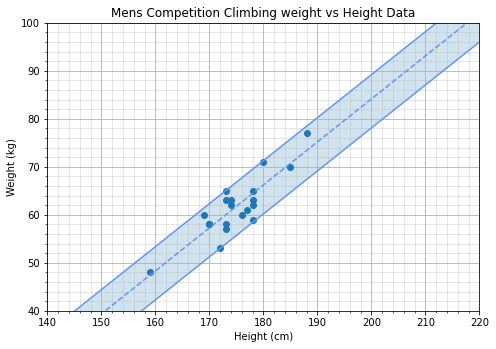

In [13]:
#create final plot
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
ax1.plot(menHeightcm, menWeightkg, "o")
ax1.plot(np.linspace(100,250),y_est, '--', color='cornflowerblue')
ax1.plot(np.linspace(100,250),y_max, color='cornflowerblue')
ax1.plot(np.linspace(100,250),y_min, color='cornflowerblue')
ax1.fill_between(np.linspace(100,250),y_min,y_max,alpha=0.2)
ax1.set_xlim(140,220)
ax1.set_ylim(40,100)
ax1.set_xticks(np.linspace(140,220,41),minor=True)
ax1.set_yticks(np.linspace(40,100,31),minor=True)
ax1.set_title('Mens Competition Climbing weight vs Height Data')
ax1.set_xlabel('Height (cm)')
ax1.set_ylabel('Weight (kg)')
ax1.grid(alpha=1)
ax1.grid(which="minor",alpha=0.4)
ax1

In [14]:
#womens Data start
womenHeightcm = list(validWomensDataFrame.iloc[:,2])
womenWeightkg = list(validWomensDataFrame.iloc[:,3])

In [15]:
#polyfit line across data
a,b = np.polyfit(womenHeightcm,womenWeightkg,deg=1)
y_est = a*np.linspace(100,250) + b

In [16]:
#find point furtherest away from polyfit line going in positive y
maxDist = 0
maxIndex = 0
aPerp=-1/a
for i in range(len(womenHeightcm)):
    newB = womenWeightkg[i]-(aPerp*womenHeightcm[i])
    newX = (b-newB)/(aPerp-a)
    newY = aPerp*newX+newB
    dist = math.sqrt((newX-womenHeightcm[i])**2 + (newY-womenWeightkg[i])**2)
    if dist > maxDist and womenWeightkg[i] > a*womenHeightcm[i]+b:
        maxDist = dist
        maxIndex = i
        
max_diff = womenWeightkg[maxIndex] - (a*womenHeightcm[maxIndex]+b)
y_max = a*np.linspace(100,250) + (b+max_diff)

In [17]:
#find point furtherest away from polyfit line going in negative y
minDist = 0
minIndex = 0
aPerp=-1/a
for i in range(len(womenHeightcm)):
    newB = womenWeightkg[i]-(aPerp*womenHeightcm[i])
    newX = (b-newB)/(aPerp-a)
    newY = aPerp*newX+newB
    dist = math.sqrt((newX-womenHeightcm[i])**2 + (newY-womenWeightkg[i])**2)
    if dist > minDist and womenWeightkg[i] < a*womenHeightcm[i]+b:
        minDist = dist
        minIndex = i
        
min_diff = womenWeightkg[minIndex] - (a*womenHeightcm[minIndex]+b)
y_min = a*np.linspace(100,250) + (b+min_diff)

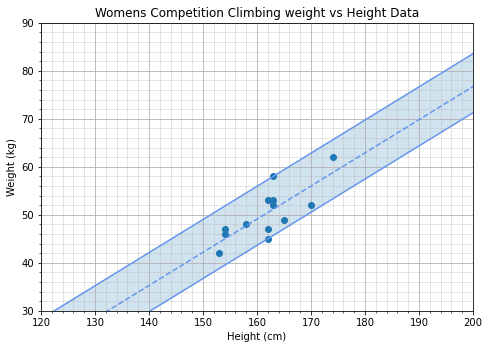

In [18]:
#create final plot
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
ax2.plot(womenHeightcm, womenWeightkg, "o")
ax2.plot(np.linspace(100,250),y_est, '--', color='cornflowerblue')
ax2.plot(np.linspace(100,250),y_max, color='cornflowerblue')
ax2.plot(np.linspace(100,250),y_min, color='cornflowerblue')
ax2.fill_between(np.linspace(100,250),y_min,y_max,alpha=0.2)
ax2.set_xlim(120,200)
ax2.set_ylim(30,90)
ax2.set_xticks(np.linspace(120,200,41),minor=True)
ax2.set_yticks(np.linspace(30,90,31),minor=True)
ax2.set_title('Womens Competition Climbing weight vs Height Data')
ax2.set_xlabel('Height (cm)')
ax2.set_ylabel('Weight (kg)')
ax2.grid(alpha=1)
ax2.grid(which="minor",alpha=0.4)
ax2